Corinne McCumber\
Professor Andrew Uhe\
IS445 Data Visualization\
1 May 2024
# Final Project: Peer View

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from collections import Counter
import ipywidgets as widgets

## 1) Dataset Information and Licensing

### Dataset name:
Track metadata from the Free Music Archive (FMA)
### Found via: 
Library of Congress https://lccn.loc.gov/2018655052
### Downloaded from: 
https://github.com/mdeff/fma \
Direct zip file download for all metadata (only tracks.csv and genres.csv are used here): https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
### License: 
Creative Commons Attribution 4.0 International License (CC BY 4.0, https://creativecommons.org/licenses/by/4.0/), which allows for sharing and adaptation so long as appropriate attribution is given.
### File size, items, description:
Tracks.csv is 254.311 MB. It contains metadata for album, artist, and specific track for the 106,574 tracks in the full FMA dataset (e.g. album date released, album listens, artist bio, artist latitude and longitude, track bit rate, track title, track genre, track listens, etc.). As such, this is a mix of integer, string, and date values. Since metadata is not complete for all tracks contained in the set, I will generally be examining metadata categories that are present for at least 95% of the dataset, discarding those tracks where metadata was not provided. One exception to this is the artist latitude and longitude data, which are only present for 23% of the tracks, but which I will be using in order to have fun with maps.

### Suggested Citation:
@inproceedings{fma_dataset, \
  title = {{FMA}: A Dataset for Music Analysis}, \
  author = {Defferrard, Michaël and Benzi, Kirell and Vandergheynst, Pierre and Bresson, Xavier}, \
  booktitle = {18th International Society for Music Information Retrieval Conference (ISMIR)}, \
  year = {2017}, \
  archiveprefix = {arXiv}, \
  eprint = {1612.01840}, \
  url = \{https://arxiv.org/abs/1612.01840 \}, \
}

## 2) Reading in and Cleaning the Dataset

In [2]:
# Display all columns for easier troubleshooting
pd.set_option('display.max_columns', None) 

df = pd.read_csv(r'data/tracks.csv', parse_dates=True, header=[0,1,2], encoding ='utf-8')

# Combine three header rows into one row to avoid MultiIndex issues. 
# Variable k is just the 'track_id' header for column 0 listed in its own separate row, which is reinstated with df.rename.
df.columns = [f'{i}_{j}' for i,j,k in df.columns] 
df.rename(columns={'Unnamed: 0_level_0_Unnamed: 0_level_1': 'track_id'}, inplace=True) 

df.shape

(106574, 53)

In [3]:
df.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [4]:
df['album_date_created'].dtypes

dtype('O')

In [5]:
# The dates aren't being read in correctly. 'album_date_created' should be datetime, not an object/text.
date_columns = ['album_date_created', 'album_date_released', 'artist_active_year_begin', 'artist_active_year_end', 'artist_date_created',
                'track_date_created', 'track_date_recorded']

for column_name in date_columns:
    df[column_name] = pd.to_datetime(df[column_name])

In [6]:
df.dtypes

track_id                             int64
album_comments                       int64
album_date_created          datetime64[ns]
album_date_released         datetime64[ns]
album_engineer                      object
album_favorites                      int64
album_id                             int64
album_information                   object
album_listens                        int64
album_producer                      object
album_tags                          object
album_title                         object
album_tracks                         int64
album_type                          object
artist_active_year_begin    datetime64[ns]
artist_active_year_end      datetime64[ns]
artist_associated_labels            object
artist_bio                          object
artist_comments                      int64
artist_date_created         datetime64[ns]
artist_favorites                     int64
artist_id                            int64
artist_latitude                    float64
artist_loca

## 3) Visualization: Track Listens vs Bit Rate
Bit rate is the number of bits conveyed per unit of time (typically seconds). With music, it can be used as shorthand for a track's audio quality. I am curious about if this simplified measure of track quality has any impact on the number of listens.  
Source for average bit rates of audio media: https://en.wikipedia.org/wiki/Bit_rate#Multimedia 

In [7]:
bit_rate_df = df.loc[:, ['track_id', 'track_bit_rate', 'track_listens']]
# track_id, track_listens, and track_bit_rate are all available for 100% of the dataset, so no need to drop any portion of the data.
bit_rate_df.shape

(106574, 3)

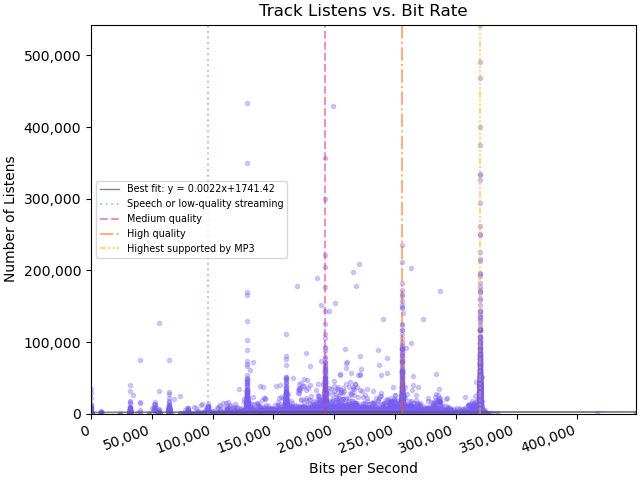

In [8]:
fig1, ax1 = plt.subplots(layout='constrained')

x = bit_rate_df['track_bit_rate']
y = bit_rate_df['track_listens']

ax1.scatter(x, y, marker='.', color='#785EF0', alpha=0.3)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, color='#525252', label=f'Best fit: y = {a:.4f}x+{b:.2f}', linestyle='solid', linewidth=1, alpha=0.7)
plt.axvline(x=96000, color='#648FFF', label='Speech or low-quality streaming', alpha=0.5, linestyle='dotted')
plt.axvline(x=192000, color='#DC267F', label='Medium quality', alpha=0.5, linestyle='dashed')
plt.axvline(x=256000, color='#FE6100', label='High quality', alpha=0.5, linestyle='dashdot')
plt.axvline(x=320000, color='#FFB000', label='Highest supported by MP3', alpha=0.5, linestyle=(0, (3, 1, 1, 1, 1, 1)))

ax1.set_title('Track Listens vs. Bit Rate')
ax1.set_xlim([x.min(), x.max()])
ax1.set_ylim([0, y.max()])
ax1.set_xlabel('Bits per Second')
ax1.set_ylabel('Number of Listens')
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.setp(ax1.get_xticklabels(), rotation=20, horizontalalignment='right')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(fontsize='x-small')

plt.show()

Hover over the figure and use the navigation keys to Pan/Zoom or Rectangle Zoom over specific parts of the figure. \
While the overall graph shows some positive correlation between bit rate and number of listens, the line of best fit shows that this effect is generally rather negligible.

## 4) Visualization: Top 10 Genres per Track by Year Interval
Genres are self-tagged by users in this dataset, and it is interesting to see the evolution of genre tagging in this dataset over time.

In [9]:
all_genre_df = df.loc[:,['track_id', 'track_date_created', 'track_genres_all']]
all_genre_df.shape

(106574, 3)

In [10]:
# track_id and track_date_created are available for 100% of the dataset. track_genres_all is available for 98%, so dropping NaN values.
# Expecting ~104,443 tracks remaining.
all_genre_df.replace('[]', np.NaN, inplace=True)
all_genre_df.dropna(inplace=True)
all_genre_df.shape

(104343, 3)

In [11]:
min_year = all_genre_df['track_date_created'].dt.year.min()
max_year = all_genre_df['track_date_created'].dt.year.max()
year_interval = widgets.IntRangeSlider(min=min_year, 
                                              max=max_year, 
                                              value=[min_year, max_year], 
                                              step=1,
                                              description='Year interval', 
                                              style={'description_width': 'initial'},
                                              readout=True, 
                                              readout_format='d')

In [12]:
year_interval

IntRangeSlider(value=(2008, 2017), description='Year interval', max=2017, min=2008, style=SliderStyle(descript…

To change year interval, move slider and rerun all cells below the slider. I chose a slider because it allows viewing of both individual years (e.g. from 2008-2008) and longer intervals (e.g. 2008-2017).

In [13]:
# Filter for desired year interval
genre_year_df=all_genre_df.loc[(all_genre_df.track_date_created.dt.year >= year_interval.value[0])
                     & (all_genre_df.track_date_created.dt.year <= year_interval.value[1])]

# Get list of all genres in desired year interval
string_list_of_lists = genre_year_df['track_genres_all'].to_list()
# Data being stored as list of string lists, e.g. ['[10]', '[17, 10, 76, 103]',...]. Need to interpret individual items in string lists.
cleaned_nested_list = []
for item in string_list_of_lists:
    cleaned_nested_list.append(item.strip('[]').split(','))
# Data now being stored as list of list of individual strings including spaces, e.g. [['10'], ['17', ' 10', ' 76', ' 103'], ...]. 
# Need to strip and flatten.
def flatten(matrix):
  return [item.strip(' ') for row in matrix for item in row]
flat_list = flatten(cleaned_nested_list)

# Get count frequency of each genre
frequency_dict = Counter(flat_list)
# Cut down to top 10 genres
top_10_dict = dict(sorted(frequency_dict.items(), key = lambda x: x[1], reverse = True)[:10])

# Replace the genre id numbers with their written counterparts for easier comparison. Genre id keys are stored in a separate csv file.
genre_df = pd.read_csv('data/genres.csv', header = 0)
title_dict = genre_df.set_index('genre_id')['title'].to_dict()
# Fixing formatting since top_10_dict uses strings for keys.
title_dict = {f'{k}':v for k, v in title_dict.items()}

top_10_dict = {title_dict[k]: v for k, v in top_10_dict.items()}
top_10_dict

{'Experimental': 38154,
 'Electronic': 34413,
 'Rock': 32923,
 'Instrumental': 14938,
 'Pop': 13845,
 'Folk': 12706,
 'Punk': 9261,
 'Avant-Garde': 8693,
 'Hip-Hop': 8389,
 'Noise': 7268}

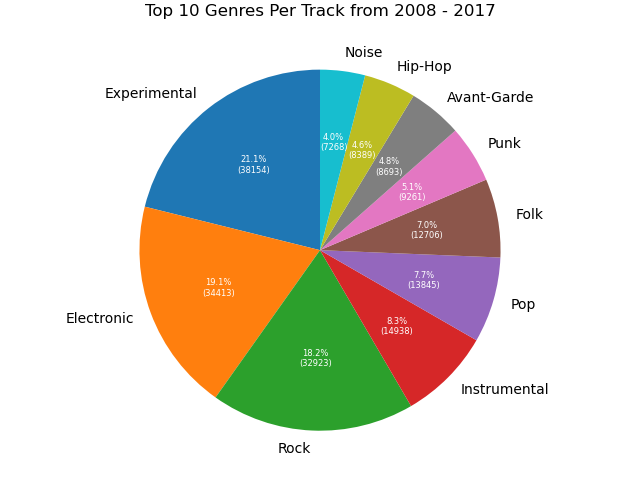

In [14]:
fig2, ax2 = plt.subplots(layout='constrained')

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_format

a, b, autopcts = ax2.pie(top_10_dict.values(),
                        labels=top_10_dict.keys(),
                        autopct=autopct_format(top_10_dict.values()),
                        labeldistance=1.1,
                        startangle=90,
                        wedgeprops={'linewidth': 1})
plt.setp(autopcts, **{'color':'white', 'fontsize':6})
ax2.set_title(f'Top 10 Genres Per Track from {year_interval.value[0]} - {year_interval.value[1]}')

plt.show()

## 5) Visualization: Top 10 Genres per Track by Year
For viewing by individual year instead of by interval. Note, I was unable to find a way to map the genres to a specific color, so the color for each genre changes for each visualization.

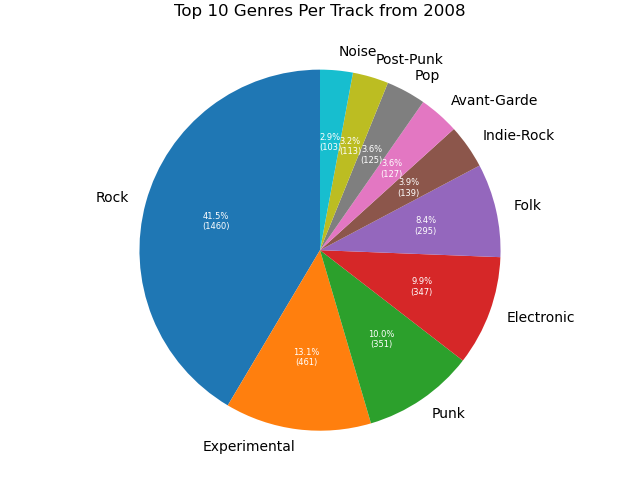

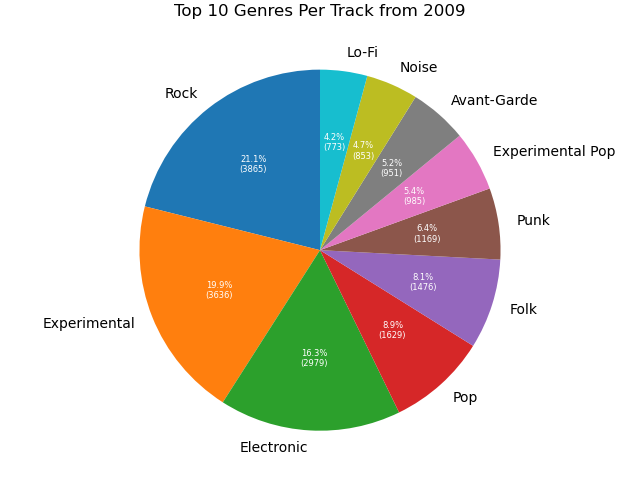

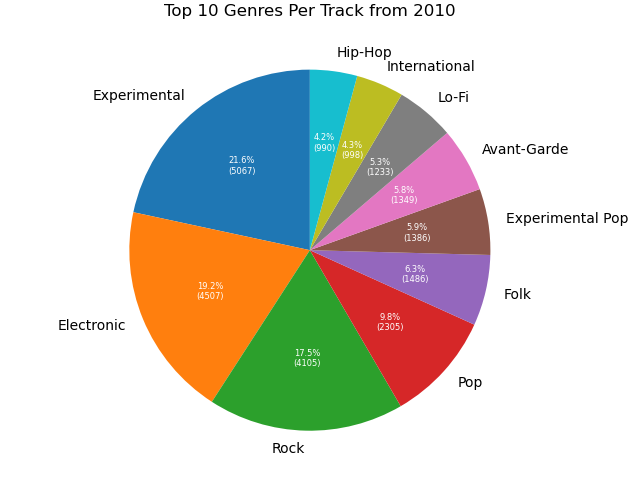

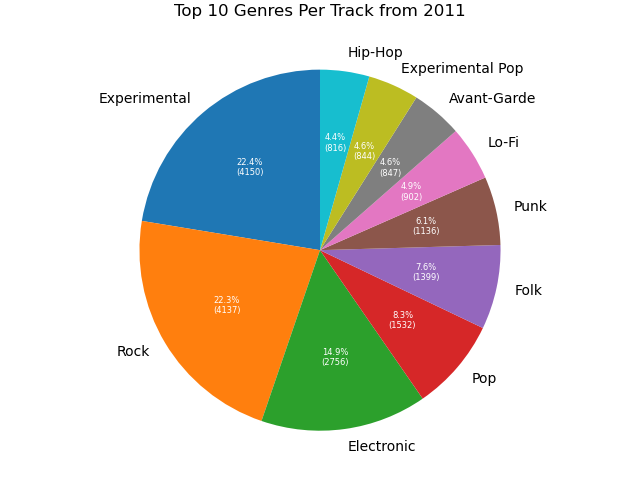

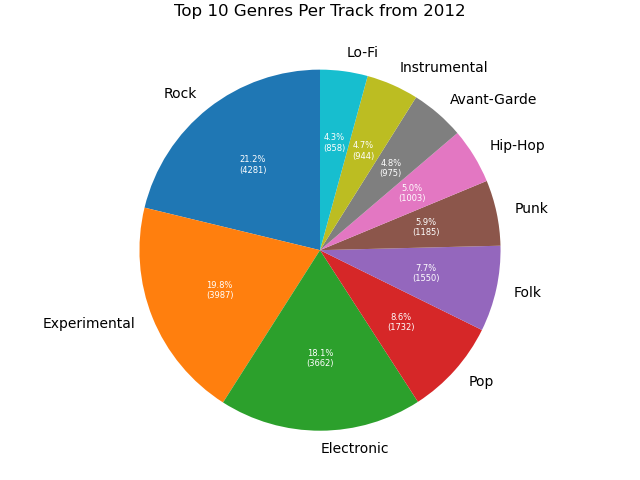

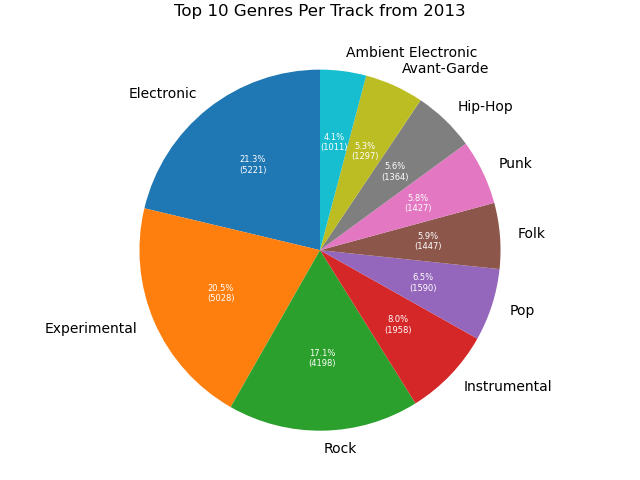

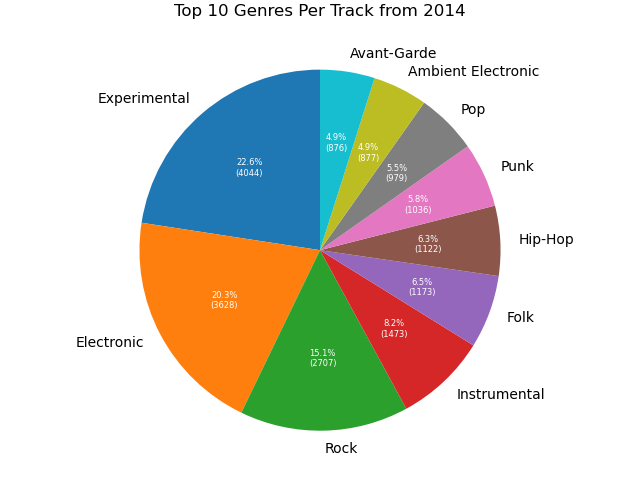

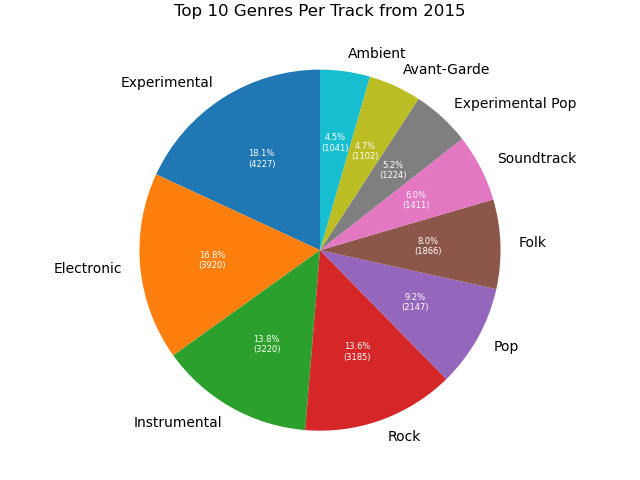

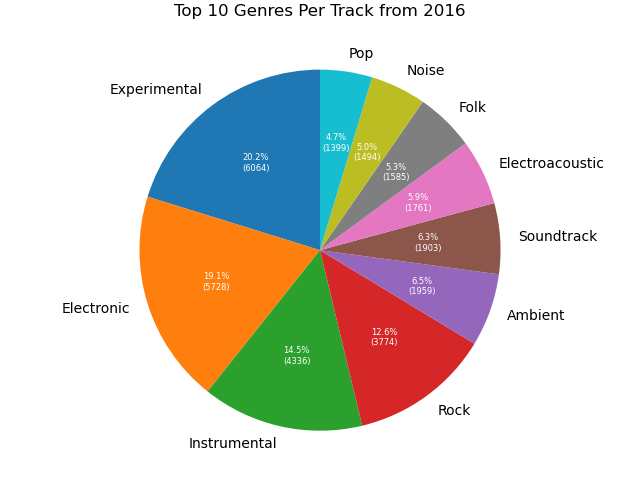

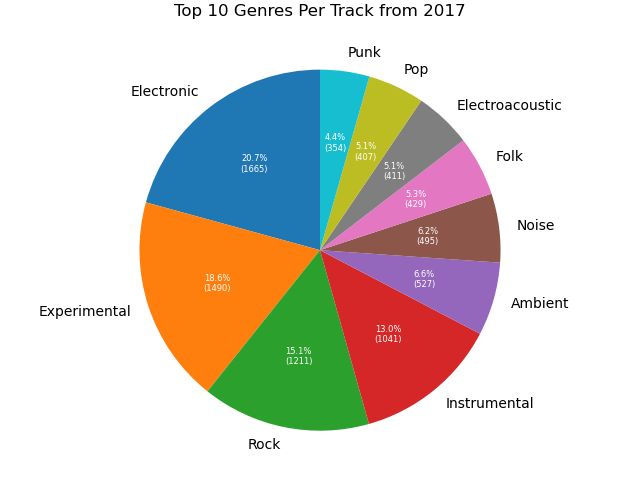

In [15]:
year_list = list(sorted(set(all_genre_df.track_date_created.dt.year)))

for year in year_list:
    # Filter for desired year 
    genre_year_df=all_genre_df.loc[(all_genre_df.track_date_created.dt.year == year)]

    # Get list of all genres in desired year
    string_list_of_lists = genre_year_df['track_genres_all'].to_list()
    # Data being stored as list of string lists, e.g. ['[10]', '[17, 10, 76, 103]',...]. Need to interpret individual items in string lists.
    cleaned_nested_list = []
    for item in string_list_of_lists:
        cleaned_nested_list.append(item.strip('[]').split(','))
    # Data now being stored as list of list of individual strings including spaces, e.g. [['10'], ['17', ' 10', ' 76', ' 103'], ...]. 
    # Need to strip and flatten.
    def flatten(matrix):
        return [item.strip(' ') for row in matrix for item in row]
    flat_list = flatten(cleaned_nested_list)

    # Get count frequency of each genre
    frequency_dict = Counter(flat_list)
    # Cut down to top 10 genres
    top_10_dict = dict(sorted(frequency_dict.items(), key = lambda x: x[1], reverse = True)[:10])

    # Replace the genre id numbers with their written counterparts for easier comparison.
    top_10_dict = {title_dict[k]: v for k, v in top_10_dict.items()}

    fig_year, ax_year = plt.subplots(layout='constrained')

    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return f'{pct:.1f}%\n({val:d})'
        return my_format

    a, b, autopcts = ax_year.pie(top_10_dict.values(),
                        labels=top_10_dict.keys(),
                        autopct=autopct_format(top_10_dict.values()),
                        labeldistance=1.1,
                        startangle=90,
                        wedgeprops={'linewidth': 1})
    plt.setp(autopcts, **{'color':'white', 'fontsize':6})
    ax_year.set_title(f'Top 10 Genres Per Track from {year}')

    plt.show()

## 5) Visualization: Track Listens vs. Duration
Do shorter songs or longer songs get more listens?

In [16]:
duration_df = df.loc[:, ['track_id', 'track_duration', 'track_listens']]
# track_id, track_duration, and track_listens all available for 100% of the dataset, so no need to drop any portion of the data.
duration_df.shape

(106574, 3)

In [17]:
# Cut off tracks over 4000 seconds as outliers.
duration_df = duration_df.loc[(duration_df.track_duration <= 4000)]
duration_df.shape

(106568, 3)

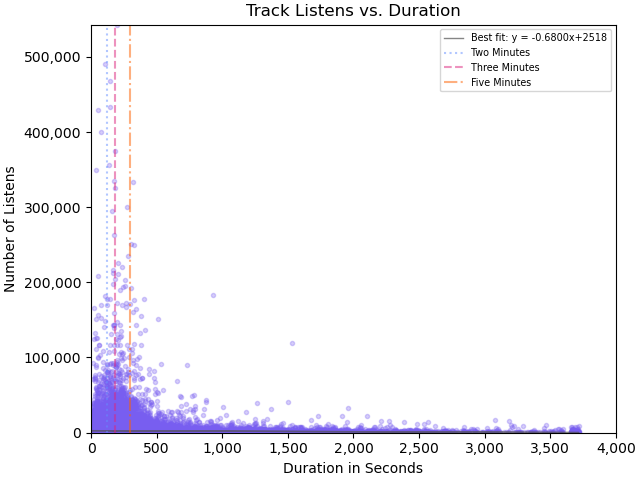

In [18]:
fig4, ax4 = plt.subplots(layout='constrained')

x = duration_df['track_duration']
y = duration_df['track_listens']

ax4.scatter(x, y, marker='.', color='#785EF0', alpha=0.3)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, color='#525252', label=f'Best fit: y = {a:.4f}x+{b:.0f}', linestyle='solid', linewidth=1, alpha=0.7)
plt.axvline(x=120, color='#648FFF', label='Two Minutes', alpha=0.5, linestyle='dotted')
plt.axvline(x=180, color='#DC267F', label='Three Minutes', alpha=0.5, linestyle='dashed')
plt.axvline(x=300, color='#FE6100', label='Five Minutes', alpha=0.5, linestyle='dashdot')

ax4.set_title('Track Listens vs. Duration')
ax4.set_xlim([x.min(), 4000])
ax4.set_ylim([0, y.max()])
ax4.set_xlabel('Duration in Seconds')
ax4.set_ylabel('Number of Listens')
ax4.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.setp(ax1.get_xticklabels(), rotation=20, horizontalalignment='right')
ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(fontsize='x-small')

plt.show()

For the dataset overall, most songs are under 5 minutes. Looking at the line of best fit, shorter songs do slightly better, though the effect is negligible.